# Receiver comparison with an over the air connection


### Documentation not done, code need tidy ups still

In [1]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from models_local import *
from OFDM_SDR_Functions_torch import *
from SDR_Pluto import *
import pandas as pd
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Display the selected device
print(device)

# Test tensor creation on the selected device
if device.type != "cpu":
    x = torch.ones(1, device=device)
    print(x)

device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps

cuda:0
tensor([1.], device='cuda:0')


In [2]:
# for SDR
SDR_TX_Frequency = int(435e6) # SDR TX frequency
tx_gain_min = -45 # sdr tx max gain
tx_gain_max = 0 # sdr tx min gain
rx_gain = 0 # sdr rx gain


In [3]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False)
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

SDR_1 = SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=-80, SDR_RX_GAIN = 0, SDR_TX_SAMPLERATE=SampleRate, SDR_TX_BANDWIDTH=F*SCS*2)
SDR_1.SDR_TX_start()


Load the model and wights

In [4]:
model = RXModel_2(Qm).to(device)

checkpoint_path = 'data/rx_model_76.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [5]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power)
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False)
    TD_TTI_IQ = FFT(Modulated_TTI)
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP)
    zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype)
    TX_Samples = torch.cat((zeros, TX_Samples), dim=0)
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

In [6]:
def radio_channel(tx_signal, tx_gain, rx_gain):
    SDR_1.SDR_gain_set(tx_gain, rx_gain)
    SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True)
    rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4)
    SDR_1.SDR_TX_stop()
    return rx_signal

In [7]:
# remove DC and FFT offsets from TTI mask_RE and add third dimension size of Qm, and expand TTI mask values into the third dimension
TTI_mask_RE_3d = TTI_mask_RE[:, FFT_offset:-FFT_offset]
middle_index = TTI_mask_RE_3d.size(1) // 2
TTI_mask_RE_3d = torch.cat((TTI_mask_RE_3d[:, :middle_index], TTI_mask_RE_3d[:, middle_index + 1:]), dim=1)
TTI_mask_RE_3d = TTI_mask_RE_3d.unsqueeze(-1).expand(S, F-1, Qm)
number_of_testcases = 100

SINR2BER_table = np.zeros((number_of_testcases,5))

for i in range(number_of_testcases):
    tx_gain_i = int(random.uniform(tx_gain_min, tx_gain_max))
    RX_Samples = radio_channel(tx_signal = TX_Samples, tx_gain = tx_gain_i, rx_gain = rx_gain)
    symbol_index=sync_TTI(TX_Samples, RX_Samples, leading_zeros=leading_zeros, threshold= 6, plot=False) + leading_zeros  # find the starting symbol of the TTI from the received signal
    SINR_sig = SINR(RX_Samples, symbol_index, leading_zeros=leading_zeros)
    RX_NO_CP = CP_removal(RX_Samples, symbol_index, S, FFT_size, CP, plotsig=False)
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False)
    OFDM_demod = OFDM_demod / torch.max(torch.abs(OFDM_demod)) # normalize DFT'd signal for NN input
    
    ## NN-receiver
    pdsch_symbols_map = remove_fft_Offests(OFDM_demod, F, FFT_offset) # remove FFT offsets
    pdsch_symbols_map = torch.cat((pdsch_symbols_map[:, :F//2], pdsch_symbols_map[:, F//2 + 1:]), dim=1).unsqueeze(0) # remove DC

    OFDM_NN = model((pdsch_symbols_map.to(device)))
    binary_predictions = torch.round(OFDM_NN)
    binary_predictions = torch.tensor(binary_predictions.squeeze()[TTI_mask_RE_3d==1].flatten().cpu(), dtype=torch.int8)

    # Calculate Bit Error Rate (BER) for the NN-receiver
    error_count = torch.sum(binary_predictions.flatten() != pdsch_bits.flatten()).float()  # Count of unequal bits
    error_rate = error_count / len(pdsch_bits.flatten())  # Error rate calculation
    BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
    
    # LS/ZF receiver
    H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=False)
    OFDM_demod_no_offsets = remove_fft_Offests(OFDM_demod, F, FFT_offset)
    equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S)
    QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=False)
    PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)
    bits_est = PS(PS_est)
    error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
    error_rate = error_count / bits_est.numel()  # Error rate calculation
    BER_LSZF = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

    if (SINR_sig[0] > 8) & (BER_LSZF > 0.4): # possibly when start index calculation fails. remove these
        i=i-1
    else:
        SINR2BER_table[i,0] = round(tx_gain_i,1)
        SINR2BER_table[i,1] = round(rx_gain,1)
        SINR2BER_table[i,2] = round(SINR_sig[0],1)
        SINR2BER_table[i,3] = BER_LSZF
        SINR2BER_table[i,4] = BER_NN

df = pd.DataFrame(SINR2BER_table, columns=['txg', 'rxg', 'SINR', 'BER_LSZF', 'BER_NN'])

directory = 'data'
base_filename = 'SINR2BER'

# Get a unique filename
filename = get_new_filename(directory, base_filename)
df.to_csv(os.path.join(directory, filename), index=False)
print(nn)
    


/tmp/ipykernel_305069/2545824784.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_predictions = torch.tensor(binary_predictions.squeeze()[TTI_mask_RE_3d==1].flatten().cpu(), dtype=torch.int8)


<module 'torch.nn' from '/home/riku/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/nn/__init__.py'>


## Plot saved SINR2BER csv

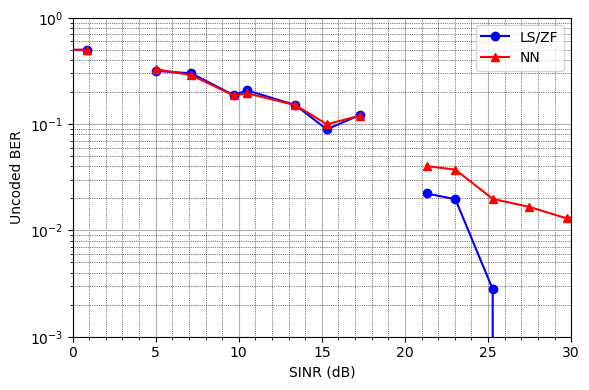

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Path to the file

#file_path = 'data/SINR2BER_0.csv'
file_path = os.path.join(directory, filename)

# Extract the number from the filename
match = re.search(r"SINR2BER_(\d+).csv", file_path)
if match:
    file_number = match.group(1)
else:
    file_number = 'unknown'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
BER_NN_mean = round(df['BER_NN'].mean()*1000)/1000
BER_LSZF_mean = round(df['BER_LSZF'].mean()*1000)/1000

df['SINR_binned'] = pd.cut(df['SINR'], bins=range(-10, 40, 2), labels=range(-9, 39, 2))
df_grouped = df.groupby('SINR_binned', observed=False).mean()

plt.figure(figsize=(6, 4))
plt.xlabel('SINR (dB)')
plt.ylabel('Uncoded BER')
plt.plot(df_grouped['SINR'], df_grouped['BER_LSZF'], '-o', color='blue', label='LS/ZF', markersize=6)
plt.plot(df_grouped['SINR'], df_grouped['BER_NN'], '-^', color='red', label = 'NN', markersize=6)
plt.legend()
#plt.title(f'Uncoded Bit Error Rate, static\n BER LS/ZF mean={BER_LSZF_mean}, BER NN mean={BER_NN_mean}')
plt.xlim(0, 30)
plt.yscale('log')
plt.ylim(1e-3, 1)   
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig(f'pics/SINR2BER_{file_number}.png')
plt.show()